<a href="https://colab.research.google.com/github/kyongmini/neuralnetqst/blob/main/QST_NN_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (1) Load the file from my github and import the necessary module

In [1]:
import requests

# GitHub의 파일 URL (raw 링크)
repo_url = "https://raw.githubusercontent.com/kyongmini/neuralnetqst/main/"
files = ["qstnn.py", "photonNMES.py"]

# 각 파일을 가져와 실행
for file in files:
    raw_url = repo_url + file
    response = requests.get(raw_url)

    if response.status_code == 200:
        print(f"✅ {file} 로드 성공!")
        exec(response.text)  # 직접 실행 (보안상 신뢰할 수 있는 코드만 실행하세요!)
    else:
        print(f"⚠️ {file} 파일을 가져오는 데 실패했습니다.")


✅ qstnn.py 로드 성공!
✅ photonNMES.py 로드 성공!


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from qiskit.visualization import array_to_latex
from scipy.linalg import sqrtm

## (2) In the Experimental Setup, we construct the Bell state or Non Maxiamlly Entangled State by using QWP, HWP before the light is propagating to BBO crystal

In [3]:
# BBO type1 downconversion makes Bell state (HH+VV)

ket_H = np.array([[1], [0]])
ket_V = np.array([[0], [1]])

ket_HH = np.kron(ket_H,ket_H)
ket_VV = np.kron(ket_V,ket_V)
epsilon = 0.98
phi = 0
Bell_state = 1/np.sqrt(1+epsilon**2) * (ket_HH + epsilon * np.exp(1j* phi) * ket_VV)
Bell_matrix = Bell_state @ Bell_state.conj().T
array_to_latex(Bell_matrix)

<IPython.core.display.Latex object>

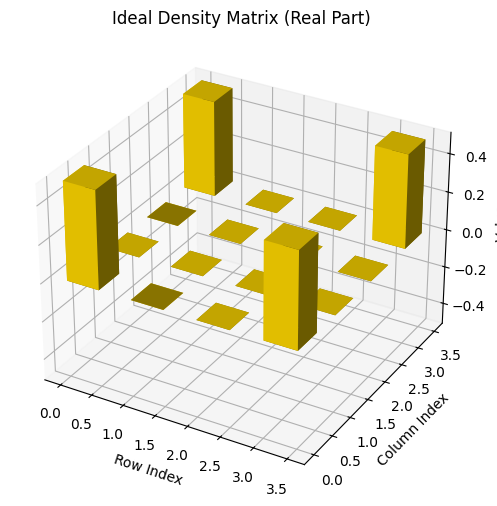

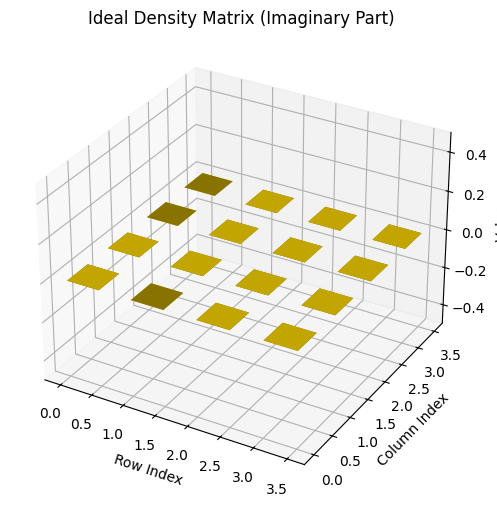

In [4]:
plot_rho(Bell_matrix.real, "Ideal Density Matrix (Real Part)")
plot_rho(Bell_matrix.imag, "Ideal Density Matrix (Imaginary Part)")

## (3) For Polarizaiton analysis, we trace revserly the light by using QWP HWP

In [5]:
HWP = np.array([(1, 0), (0, -1)])  # HWP matrix
QWP = np.array([(1, 0), (0, 1j)])  # QWP matrix

# the H polarization after the transmission of PBS; it's necessary work!!
PBS_t_state = ket_H

# Control with angles h, q
H = polarization_analysis(0, 0)
V = 1j*polarization_analysis(np.pi/4, 0)
D = polarization_analysis(np.pi/8, np.pi/4)
A = polarization_analysis(-np.pi/8, -np.pi/4)
L = polarization_analysis(-np.pi/8, 0)
R = polarization_analysis(np.pi/8, 0)

## (4) Set the measurement basis we want to use

In [6]:
basis=[
np.kron(H, H),
np.kron(H, V),
np.kron(V, H),
np.kron(V, V),
np.kron(H, D),
np.kron(H, L),
np.kron(D, H),
np.kron(R, H),
np.kron(D, D),
np.kron(R, D),
np.kron(R, L),
np.kron(D, R),
np.kron(D, V),
np.kron(R, V),
np.kron(V, D),
np.kron(V, L)]

Measurement_matrix = []

for j in range(len(basis)):
    Measurement_matrix.append(basis[j] @ basis[j].conj().T)

In [7]:
coincidence_count = []
for j in range(len(basis)):
    count = np.trace(Measurement_matrix[j] @ Bell_matrix)
    coincidence_count.append(np.real(count))
print(coincidence_count)

[np.float64(0.5100999795960007), np.float64(1.641365230148509e-32), np.float64(1.641365230148509e-32), np.float64(0.48990002040399905), np.float64(0.2550499897980004), np.float64(0.2550499897980003), np.float64(0.2550499897980004), np.float64(0.2550499897980003), np.float64(0.4999489900020403), np.float64(0.24999999999999983), np.float64(0.4999489900020403), np.float64(0.24999999999999983), np.float64(0.24495001020199947), np.float64(0.24495001020199947), np.float64(0.24495001020199947), np.float64(0.2449500102019997)]


In [8]:
normalized_cc = coincidence_count / (coincidence_count[0]+coincidence_count[1]+coincidence_count[2]+coincidence_count[3])
print(normalized_cc)

[5.10099980e-01 1.64136523e-32 1.64136523e-32 4.89900020e-01
 2.55049990e-01 2.55049990e-01 2.55049990e-01 2.55049990e-01
 4.99948990e-01 2.50000000e-01 4.99948990e-01 2.50000000e-01
 2.44950010e-01 2.44950010e-01 2.44950010e-01 2.44950010e-01]


## (5) Adjust the parameters for reconstructing density matrix

In [9]:
# ===== Adjustable parameters =====
params = {
    'n_visible': 2,            # 두 큐빗 시스템 (2비트 → 4 상태)
    'n_hidden': 4,             # hidden 유닛 수 (조정 가능)
    'n_samples': 500,           # 학습에 사용할 총 샘플 수
    'epochs': 100,             # 학습 에포크 수
    'batch_size': 50,          # 미니배치 크기
    'learning_rate': 0.01,   # 학습률
    'gibbs_steps': 1           # Gibbs 샘플링 단계 수
}

print("조정 가능한 파라미터:")
for key, value in params.items():
    print(f"{key}: {value}")

조정 가능한 파라미터:
n_visible: 2
n_hidden: 4
n_samples: 500
epochs: 100
batch_size: 50
learning_rate: 0.01
gibbs_steps: 1


Epoch 10/100, Loss: -0.0001
Epoch 20/100, Loss: -0.0020
Epoch 30/100, Loss: -0.0003
Epoch 40/100, Loss: 0.0018
Epoch 50/100, Loss: 0.0001
Epoch 60/100, Loss: -0.0004
Epoch 70/100, Loss: -0.0001
Epoch 80/100, Loss: 0.0007
Epoch 90/100, Loss: 0.0009
Epoch 100/100, Loss: 0.0013


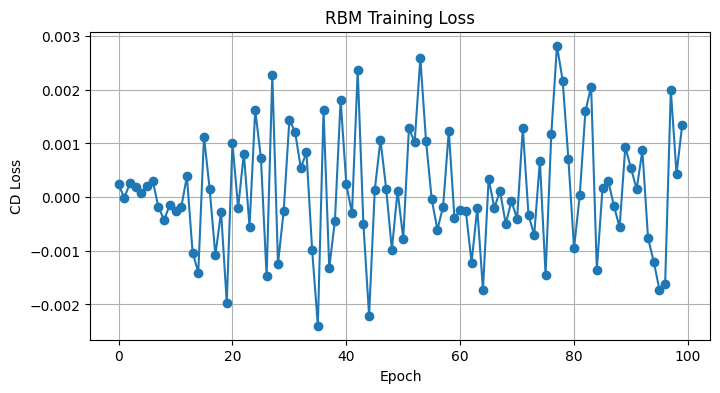

In [10]:
# ===== Main simulation: RBM Training and Reconstruction =====
n_visible = params['n_visible']
n_hidden = params['n_hidden']
n_samples = params['n_samples']
epochs = params['epochs']
batch_size = params['batch_size']
lr = params['learning_rate']
k = params['gibbs_steps']

data = generate_ideal_state_samples(n_visible, n_samples, Bell_state.flatten())
rbm = RBM(n_visible, n_hidden)
losses = train_rbm(rbm, data, epochs, batch_size, lr, k)

plt.figure(figsize=(8,4))
plt.plot(losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("CD Loss")
plt.title("RBM Training Loss")
plt.grid(True)
plt.show()

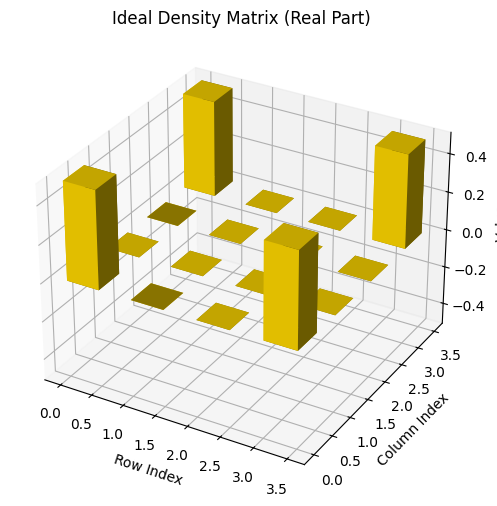

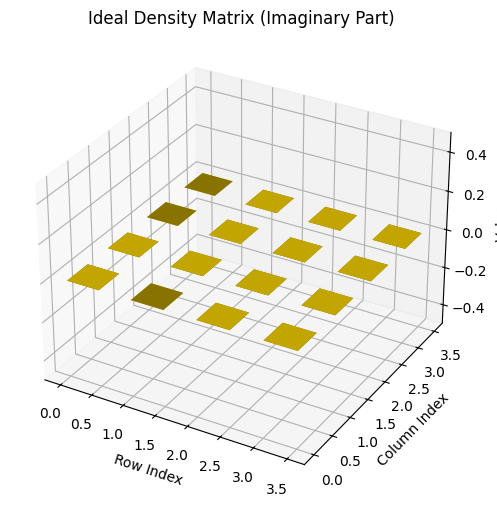

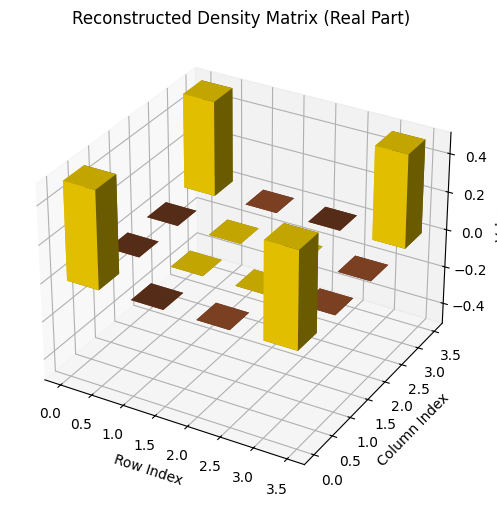

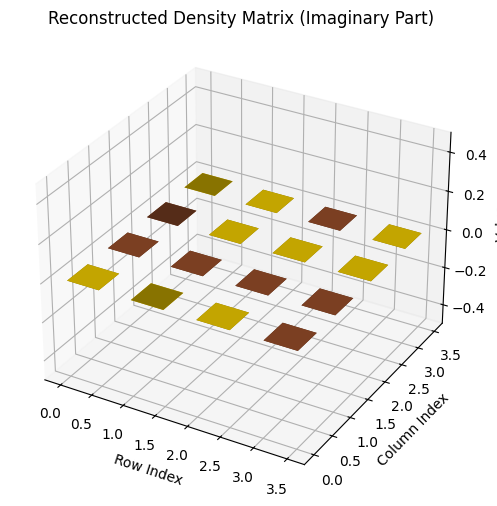

In [11]:
A = np.array([m.reshape(16) for m in Measurement_matrix])
r, residuals, rank, s = np.linalg.lstsq(A, coincidence_count, rcond=None)
reconstructed_rho = r.reshape(4, 4)
reconstructed_rho = reconstructed_rho / np.trace(reconstructed_rho)
reconstructed_rho = np.conjugate(reconstructed_rho)


# 음수 고윳값 보정: eigen-decomposition 후 음수 값은 0으로 클리핑
eigvals, eigvecs = np.linalg.eigh(reconstructed_rho)
eigvals_fixed = np.clip(eigvals, 0, None)  # 음수 고윳값을 0으로 설정
reconstructed_rho = eigvecs @ np.diag(eigvals_fixed) @ eigvecs.conj().T

# 보정 후 trace=1이 되도록 다시 normalize
reconstructed_rho = reconstructed_rho / np.trace(reconstructed_rho)

# ===== 3D 시각화 (z축 고정) =====
plot_rho(Bell_matrix.real, "Ideal Density Matrix (Real Part)")
plot_rho(Bell_matrix.imag, "Ideal Density Matrix (Imaginary Part)")
plot_rho(reconstructed_rho.real, "Reconstructed Density Matrix (Real Part)")
plot_rho(reconstructed_rho.imag, "Reconstructed Density Matrix (Imaginary Part)")


## (5) Check the final results and calculate the fidelity and purity

In [12]:
array_to_latex(Bell_matrix)

<IPython.core.display.Latex object>

In [13]:
array_to_latex(reconstructed_rho)

<IPython.core.display.Latex object>

In [16]:
fidelity(Bell_matrix,reconstructed_rho)

0.9999999824827465401


In [18]:
purity(reconstructed_rho)

0.9999999999999987
